Total points in cloud: 5138


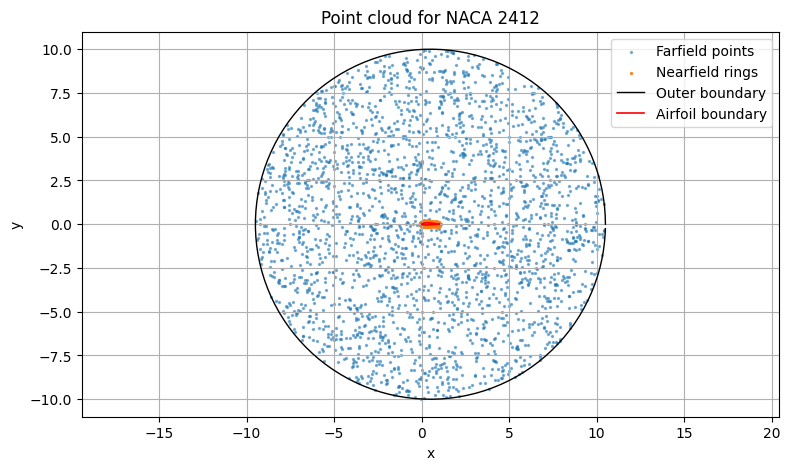

In [1]:
# --- Path setup so Jupyter can find src/ ---
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()     # scripts/ is one level below project root
SRC_PATH = PROJECT_ROOT / "src"
sys.path.append(str(SRC_PATH))

# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt

from meshgen.naca4 import gen_naca4
from meshgen.domain import (
    gen_outer_boundary,
    make_offset_distances,
    airfoil_offset_rings,
    sample_farfield_points,
    build_point_cloud,
)

# --- Parameters ---
code = "2412"
chord = 1.0
n_chord = 200

outer_radius_factor = 10.0
n_outer = 250

base_frac = 0.005
n_layers = 5
growth = 2.0

n_far = 2500
rng = np.random.default_rng(0)

# --- Geometry ---
airfoil = gen_naca4(code, chord=chord, n_chord=n_chord)

outer = gen_outer_boundary(
    radius=outer_radius_factor * chord,
    n_points=n_outer,
    center=(0.5 * chord, 0.0),
)

# --- Nearfield refinement ---
distances = make_offset_distances(
    base=base_frac * chord,
    n_layers=n_layers,
    growth=growth,
)

near = airfoil_offset_rings(airfoil, distances=distances)

# --- Farfield interior points ---
far = sample_farfield_points(
    outer_boundary=outer,
    airfoil_boundary=airfoil,
    n_points=n_far,
    min_dist_to_airfoil=distances[-1],
    rng=rng,
)

# --- Combined point cloud ---
points = build_point_cloud(
    airfoil_boundary=airfoil,
    outer_boundary=outer,
    nearfield_points=near,
    farfield_points=far,
    deduplicate=True,
    dedup_tol=1e-12,
)

print(f"Total points in cloud: {points.shape[0]}")

# --- Plot ---
plt.figure(figsize=(9, 5))

# Farfield + nearfield
plt.scatter(far[:, 0], far[:, 1], s=2, alpha=0.5, label="Farfield points")
plt.scatter(near[:, 0], near[:, 1], s=2, alpha=0.9, label="Nearfield rings")

# Boundaries
plt.plot(outer[:, 0], outer[:, 1], "-k", lw=1.0, label="Outer boundary")
plt.plot(airfoil[:, 0], airfoil[:, 1], "-r", lw=1.2, label="Airfoil boundary")

plt.axis("equal")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Point cloud for NACA {code}")
plt.legend(loc="upper right")
plt.show()


In [5]:
from shapely.geometry import Polygon
from meshgen.naca4 import gen_naca4
airfoil = gen_naca4("2412", chord=1.0, n_chord=200)
repaired = Polygon(airfoil).buffer(0)
print(repaired.is_valid)

True


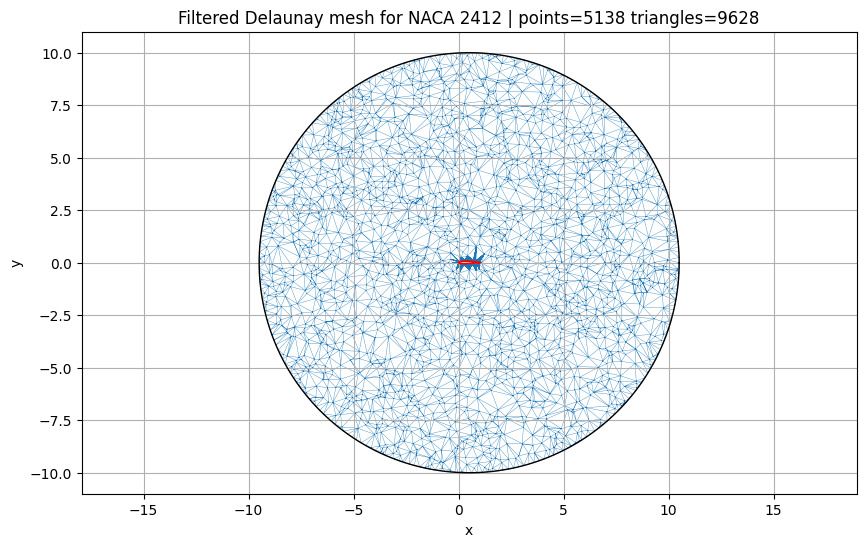

In [2]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

from meshgen.naca4 import gen_naca4
from meshgen.domain import (
    gen_outer_boundary,
    make_offset_distances,
    airfoil_offset_rings,
    sample_farfield_points,
    build_point_cloud,
)
from meshgen.triangulate import generate_mesh

code = "2412"
chord = 1.0
n_chord = 200

outer_radius_factor = 10.0
n_outer = 250

base_frac = 0.005
n_layers = 5
growth = 2.0

n_far = 2500
rng = np.random.default_rng(0)

airfoil = gen_naca4(code, chord=chord, n_chord=n_chord)
outer = gen_outer_boundary(
    radius=outer_radius_factor * chord,
    n_points=n_outer,
    center=(0.5 * chord, 0.0),
)

distances = make_offset_distances(base=base_frac * chord, n_layers=n_layers, growth=growth)
near = airfoil_offset_rings(airfoil, distances=distances)

far = sample_farfield_points(
    outer_boundary=outer,
    airfoil_boundary=airfoil,
    n_points=n_far,
    min_dist_to_airfoil=distances[-1],
    rng=rng,
)

points = build_point_cloud(
    airfoil_boundary=airfoil,
    outer_boundary=outer,
    nearfield_points=near,
    farfield_points=far,
    deduplicate=True,
    dedup_tol=1e-12,
)

pts, tris = generate_mesh(points, outer, airfoil)

tri_obj = mtri.Triangulation(pts[:, 0], pts[:, 1], tris)

plt.figure(figsize=(10, 6))
plt.triplot(tri_obj, lw=0.25)
outer_closed = np.vstack([outer, outer[0]])
plt.plot(outer_closed[:, 0], outer_closed[:, 1], "-k", lw=1.0)
plt.plot(airfoil[:, 0], airfoil[:, 1], "-r", lw=1.2)

plt.axis("equal")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Filtered Delaunay mesh for NACA {code} | points={pts.shape[0]} triangles={tris.shape[0]}")
plt.show()